In [15]:
from NOAAStations import TidalStation
from DeviceModels import Turbine, calculate_power
from Calculator import maintenance, operation, installation

import pandas as pd
import os
from ipywidgets import widgets, interact, fixed
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
import scipy
import scipy.interpolate
from contextlib import redirect_stdout
figsize(12, 10)
sbn.set_context("paper", font_scale=1)
sbn.set_style("whitegrid")


from collections import namedtuple


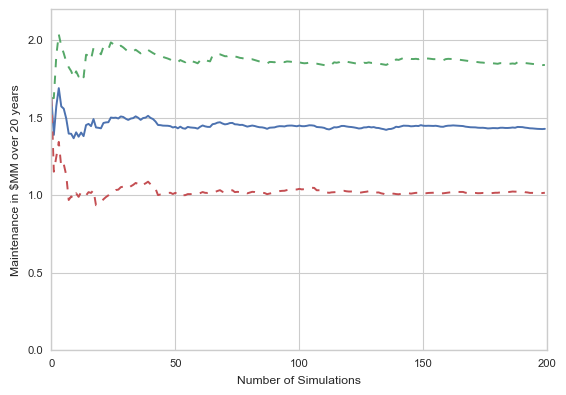

In [16]:
Maintenance_Rate = namedtuple('Parameter', 'partname minimal_rate midlevel_rate severe_rate minimal_cost midlevel_cost severe_cost number labor')


emergency_maintenance = [
    Maintenance_Rate('Blade', 0.042, 0.0273, 0.00007, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Others', 0.03, 0.0299, 0.00006, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Gear Box',0.2125, 0.0325, 0.0005, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Electricity Generator', 0.065, 0.0545, 0.0065, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Shaft', 0.002, 0.007, .001, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Brake', 0.0153, 0.0325, 0.0025,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Cable', 0.225, 0.09247, 0.000002,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Control system', 0.1, 0.1, 0.0001,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.)
]


emergency_events = [maintenance.EmergencyMaintenance(
            e.minimal_rate, 
            e.midlevel_rate, 
            e.severe_rate,
            e.minimal_cost, 
            e.midlevel_cost, 
            e.severe_cost,
            number = e.number, 
            labor = e.labor, 
            partname = e.partname)
            for e in emergency_maintenance]

runs = 200
costs = np.zeros(runs)
tracking_average = np.zeros(runs)
tracking_error = np.zeros(runs)

for i in range(runs):
    time, cost = maintenance.lifetimeMonteCarlo(20, emergency_events)
    costs[i] = cost/1e6
    tracking_average[i] = np.mean(costs[:i+1])
    tracking_error[i] = np.std(costs[:i+1])    

plt.plot(tracking_average, '-')
plt.plot(tracking_average+tracking_error, '--')
plt.plot(tracking_average-tracking_error, '--')
plt.xlabel('Number of Simulations')
plt.ylabel('Maintenance in $MM over 20 years')
plt.ylim(0,)

plt.savefig('montecaro.png')
    

In [ ]:

import plotly.plotly as py
import plotly.graph_objs as go

def richardsCurve(Velocity,K,Q,B,M,g):
    return K*(1+Q*np.exp(-1*B*(Velocity-M)))**(-1/g)

import scipy.optimize
import numpy as np

velocities = np.array([0,.5,1,1.5,2,2.5,3,3.5,4])
power = np.array([0,20,75,300,800, 1100, 1175, 1195, 1200])

# starting_guess = (1, 1, 1)

# optimized_parameters, covariance = scipy.optimize.curve_fit(richardsCurve, 
#                                                                  xdata = velocities, 
#                                                                  ydata = power, 
#                                                                  p0 = starting_guess)
x = np.linspace(0,4)
y = richardsCurve(x,  1200., 0.1835, 3.55361367,  2.30706792,  1.05659521)
y2 = richardsCurve(x, 1164.785 , 2.834 , 2.778 , 1.020 , 0.751)
%matplotlib inline
from matplotlib import pyplot as plt

# plt.plot(x,y)
# plt.ylabel('Power (kW)')
# plt.xlabel('Flow Speed (m/s)')
# plt.savefig('RichardsCurve.png', format='png', transparent=True, bbox_inches='tight')

trace = [go.Scatter(
    x = x,
    y = y,
    mode = 'lines',
    name = 'Richards Curve Model',
    line = dict(color = 'rgb(52, 165, 218)')
    ),
        go.Scatter(
    x = x,
    y = y2,
    name = 'SeaGen Performance',
    mode = 'lines',
    line = dict(color = 'orange')
        )
        ]


layout = go.Layout(
    title = 'Richards Curve | SeaGen',
    titlefont = dict(
        size = 26,
        color = 'white'),
    xaxis = dict(title = 'Power (kW)',
        titlefont = dict(
        size = 20,
        color = 'white'),
        tickfont=dict(
            size=16,
            color='white'
        )),
    yaxis = dict(title = 'Velocity (m/s)',
        titlefont = dict(
        size = 20,
        color = 'white'),
        tickfont=dict(
            size=16,
            color='white'
        )),
    paper_bgcolor='transparent',
    plot_bgcolor='transparent')

fig = go.Figure(data = trace, layout=layout)
py.iplot(fig, filename='RichardsCurve')